In [136]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from matplotlib import pyplot

In [104]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [105]:
# Reading datasetss
df_stock_train = pd.read_csv("../data/DATA_STOCK_VARS_TRAIN_F.csv")
df_stock_test = pd.read_csv("../data/DATA_STOCK_VARS_TEST_F.csv")

# Primer modelo base con RF y one_hot

## Preprocessing

In [106]:
df_stock_train_p = df_stock_train.copy()
df_stock_test_p = df_stock_test.copy()

In [107]:
df_stock_train_p.head(1).T

,0
ID,201808_48117
MES_T0,201808
ID_CLIENTE,48117
FUGA_3M,0
FH_NACIMIENTO,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,8
RGO_SDO_MEDIO_ACTIVO,6
RGO_SDO_MEDIO_PASIVO,9


In [108]:
df_stock_train_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73661 entries, 0 to 73660
Data columns (total 20 columns):
ID                      73661 non-null object
MES_T0                  73661 non-null int64
ID_CLIENTE              73661 non-null int64
FUGA_3M                 73661 non-null int64
FH_NACIMIENTO           72765 non-null object
FH_ALTA                 72852 non-null object
RGO_RIEGO_BBVA          73661 non-null int64
RGO_RIESGO_SIST         73661 non-null int64
RGO_SDO_MEDIO_ACTIVO    73661 non-null int64
RGO_SDO_MEDIO_PASIVO    73661 non-null int64
RGO_MARGEN_OPER_MES     73661 non-null int64
RGO_MARGEN_OPER_ACUM    73661 non-null int64
RGO_FACTURA_ANUAL       73661 non-null int64
TO_EMPLEADOS            72211 non-null float64
CD_SBS_NORMAL           51297 non-null float64
CD_SBS_CPP              51297 non-null float64
CD_SBS_DDP              51297 non-null float64
TP_VIVI                 72734 non-null object
TP_PERSONA              73661 non-null object
TIPO_NEGOCIO           

# Primer modelo. XGBoost sin inputaciones (valores nulos) y sólo relleno de nans para hacer one_hot en tipo de vivienda. One_hot en resto de categoricas tmb. Computo de meses desde nacimiento y alta.

In [109]:
#Llenando nulos porque son importantes en la distribucion, excepto para total de empleados (se dejara en null de momento)
df_stock_train_p['TP_VIVI'].fillna('nan_value', inplace=True)
df_stock_test_p['TP_VIVI'].fillna('nan_value', inplace=True)

In [110]:
#Computando nuevas columnas de meses hasta la fecha de nacimiento y alta.

#Numero de meses hasta la fecha de nacimiento desde año 0 mes 0.
df_stock_train_p['months_NACIMIENTO'] = df_stock_train_p['FH_NACIMIENTO'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)
df_stock_test_p['months_NACIMIENTO'] = df_stock_test_p['FH_NACIMIENTO'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)

#Numero de meses basta fecha de alta desde año 0 mes 0
df_stock_train_p['months_ALTA'] = df_stock_train_p['FH_ALTA'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)
df_stock_test_p['months_ALTA'] = df_stock_test_p['FH_ALTA'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)

#Computando los meses del T0 desde el año 0 mes 0
df_stock_train_p['months_T0'] = df_stock_train_p['MES_T0'].apply(lambda x: int(str(x)[:4])*12 + int(str(x)[4:6]))
df_stock_test_p['months_T0'] = df_stock_test_p['MES_T0'].apply(lambda x: int(str(x)[:4])*12 + int(str(x)[4:6]))

#Computando columnas finales
df_stock_train_p['diff_months_T0_NACIMIENTO'] = df_stock_train_p['months_T0'] - df_stock_train_p['months_NACIMIENTO']
df_stock_test_p['diff_months_T0_NACIMIENTO'] = df_stock_test_p['months_T0'] - df_stock_test_p['months_NACIMIENTO']

df_stock_train_p['diff_months_T0_ALTA'] = df_stock_train_p['months_T0'] - df_stock_train_p['months_ALTA']
df_stock_test_p['diff_months_T0_ALTA'] = df_stock_test_p['months_T0'] - df_stock_test_p['months_ALTA']

In [111]:
df_stock_train_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73661 entries, 0 to 73660
Data columns (total 25 columns):
ID                           73661 non-null object
MES_T0                       73661 non-null int64
ID_CLIENTE                   73661 non-null int64
FUGA_3M                      73661 non-null int64
FH_NACIMIENTO                72765 non-null object
FH_ALTA                      72852 non-null object
RGO_RIEGO_BBVA               73661 non-null int64
RGO_RIESGO_SIST              73661 non-null int64
RGO_SDO_MEDIO_ACTIVO         73661 non-null int64
RGO_SDO_MEDIO_PASIVO         73661 non-null int64
RGO_MARGEN_OPER_MES          73661 non-null int64
RGO_MARGEN_OPER_ACUM         73661 non-null int64
RGO_FACTURA_ANUAL            73661 non-null int64
TO_EMPLEADOS                 72211 non-null float64
CD_SBS_NORMAL                51297 non-null float64
CD_SBS_CPP                   51297 non-null float64
CD_SBS_DDP                   51297 non-null float64
TP_VIVI                      7

In [112]:
cat_cols = ['TP_VIVI','TP_PERSONA','TIPO_NEGOCIO']
intermediate_cols = ['months_NACIMIENTO','months_ALTA','months_T0']

In [113]:
df_stock_train_p = pd.concat([df_stock_train_p,pd.get_dummies(df_stock_train_p['TP_VIVI'], prefix='TP_VIVI')],axis=1)
df_stock_train_p = pd.concat([df_stock_train_p,pd.get_dummies(df_stock_train_p['TP_PERSONA'], prefix='TP_PERSONA')],axis=1)
df_stock_train_p = pd.concat([df_stock_train_p,pd.get_dummies(df_stock_train_p['TIPO_NEGOCIO'], prefix='TIPO_NEGOCIO')],axis=1)


df_stock_test_p = pd.concat([df_stock_test_p,pd.get_dummies(df_stock_test_p['TP_VIVI'], prefix='TP_VIVI')],axis=1)
df_stock_test_p = pd.concat([df_stock_test_p,pd.get_dummies(df_stock_test_p['TP_PERSONA'], prefix='TP_PERSONA')],axis=1)
df_stock_test_p = pd.concat([df_stock_test_p,pd.get_dummies(df_stock_test_p['TIPO_NEGOCIO'], prefix='TIPO_NEGOCIO')],axis=1)

In [114]:
df_stock_train_p.head(1).T

,0
ID,201808_48117
MES_T0,201808
ID_CLIENTE,48117
FUGA_3M,0
FH_NACIMIENTO,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,8
RGO_SDO_MEDIO_ACTIVO,6
RGO_SDO_MEDIO_PASIVO,9


In [115]:
fit_cols = list(set(df_stock_train_p.columns)
                - set(cat_cols) 
                - set(intermediate_cols) 
                - set(['MES_T0','ID_CLIENTE','FH_ALTA','FH_NACIMIENTO']))
fit_cols

['TP_VIVI_HOGAR',
 'TP_PERSONA_J',
 'TIPO_NEGOCIO_Pyme',
 'CD_SBS_NORMAL',
 'TP_PERSONA_A',
 'TO_EMPLEADOS',
 'RGO_MARGEN_OPER_MES',
 'RGO_SDO_MEDIO_PASIVO',
 'TP_VIVI_nan_value',
 'TP_VIVI_LEGAL',
 'RGO_RIEGO_BBVA',
 'TP_PERSONA_F',
 'RGO_MARGEN_OPER_ACUM',
 'CD_SBS_DDP',
 'diff_months_T0_NACIMIENTO',
 'FUGA_3M',
 'RGO_FACTURA_ANUAL',
 'RGO_SDO_MEDIO_ACTIVO',
 'diff_months_T0_ALTA',
 'CD_SBS_CPP',
 'TP_VIVI_TRABAJO',
 'RGO_RIESGO_SIST',
 'TIPO_NEGOCIO_PNN',
 'ID']

In [116]:
# Final datasets
df_stock_train_f = df_stock_train_p[fit_cols]
df_stock_test_f = df_stock_test_p[fit_cols]

In [117]:
df_stock_train_f.head(1).T

,0
TP_VIVI_HOGAR,0
TP_PERSONA_J,1
TIPO_NEGOCIO_Pyme,1
CD_SBS_NORMAL,100
TP_PERSONA_A,0
TO_EMPLEADOS,2
RGO_MARGEN_OPER_MES,1
RGO_SDO_MEDIO_PASIVO,9
TP_VIVI_nan_value,0
TP_VIVI_LEGAL,1


In [118]:
final_cols = list(set(fit_cols)-set(['ID','FUGA_3M']))

In [119]:
ids = df_stock_train_f['ID']
X = df_stock_train_f[final_cols]
y = df_stock_train_f['FUGA_3M']

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [121]:
y_train.value_counts(normalize = True)

0    0.866277
1    0.133723
Name: FUGA_3M, dtype: float64

In [122]:
y_test.value_counts(normalize = True)

0    0.866287
1    0.133713
Name: FUGA_3M, dtype: float64

# Fitting

In [123]:
#vc
xgb = XGBClassifier(learning_rate =0.1,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scale_pos_weight=1,
                 seed=42)

In [124]:
#fit
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
       subsample=0.8, verbosity=1)

In [125]:
#Getting results
y_pred = xgb.predict_proba(X_test)

In [130]:
y_pred

array([[0.9955869 , 0.00441313],
       [0.9706547 , 0.02934529],
       [0.96444875, 0.03555122],
       ...,
       [0.9763416 , 0.02365838],
       [0.45665854, 0.54334146],
       [0.866269  , 0.13373102]], dtype=float32)

In [131]:
y_pred_final = y_pred[:,1]

In [132]:
# First result
roc_auc_score(y_test, y_pred_final)

0.7825352551852177

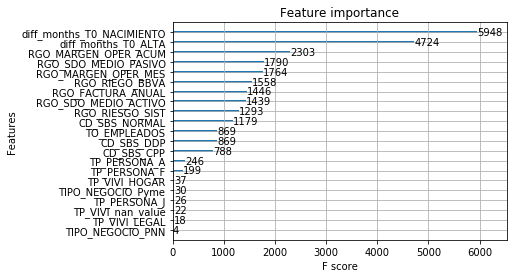

In [182]:
plot_importance(xgb)
pyplot.show()

# Segundo modelo. Target encoding a variables categoricas

In [161]:
# Recogido de: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [162]:
df_stock_train_p2 = df_stock_train.copy()
df_stock_test_p2 = df_stock_test.copy()

In [163]:
#Llenando nulos porque son importantes en la distribucion, excepto para total de empleados (se dejara en null de momento)
df_stock_train_p2['TP_VIVI'].fillna('nan_value', inplace=True)
df_stock_test_p2['TP_VIVI'].fillna('nan_value', inplace=True)

In [164]:
#Partiendo en train y val de una vez, para probar te
X_2 = df_stock_train_p2[list(set(df_stock_train_p2.columns) - set('FUGA_3M'))]
y_2 = df_stock_train_p2['FUGA_3M']

In [165]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.3, random_state = 42, stratify = y)

In [166]:
#Testeando el te para vivienda
df_stock_train_p2_vivi_enc = target_encode(X_train_2['TP_VIVI'], 
                                           X_test_2['TP_VIVI'], 
                                           y_train_2)

In [167]:
#Testeando el te para tipo_persona
df_stock_train_p2_pers_enc = target_encode(X_train_2['TP_PERSONA'], 
                                           X_test_2['TP_PERSONA'], 
                                           y_train_2)

In [168]:
#Testeando el te para tipo_negocio
df_stock_train_p2_neg_enc = target_encode(X_train_2['TIPO_NEGOCIO'], 
                                           X_test_2['TIPO_NEGOCIO'], 
                                           y_train_2)

In [169]:
X_train_2 = pd.concat([X_train_2,df_stock_train_p2_vivi_enc[0]],axis=1)
X_test_2 = pd.concat([X_test_2,df_stock_train_p2_vivi_enc[1]],axis=1)

X_train_2 = pd.concat([X_train_2,df_stock_train_p2_pers_enc[0]],axis=1)
X_test_2 = pd.concat([X_test_2,df_stock_train_p2_pers_enc[1]],axis=1)

X_train_2 = pd.concat([X_train_2,df_stock_train_p2_neg_enc[0]],axis=1)
X_test_2 = pd.concat([X_test_2,df_stock_train_p2_neg_enc[1]],axis=1)

In [170]:
# Agregando columnas de los meses desde nacimiento y alta.

#Numero de meses hasta la fecha de nacimiento desde año 0 mes 0.
X_train_2['months_NACIMIENTO'] = X_train_2['FH_NACIMIENTO'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)
X_test_2['months_NACIMIENTO'] = X_test_2['FH_NACIMIENTO'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)

#Numero de meses basta fecha de alta desde año 0 mes 0
X_train_2['months_ALTA'] = X_train_2['FH_ALTA'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)
X_test_2['months_ALTA'] = X_test_2['FH_ALTA'].apply(lambda x: int(str(x).split('-')[0])*12 + int(str(x).split('-')[1]) if isinstance(x, str) else x)

#Computando los meses del T0 desde el año 0 mes 0
X_train_2['months_T0'] = X_train_2['MES_T0'].apply(lambda x: int(str(x)[:4])*12 + int(str(x)[4:6]))
X_test_2['months_T0'] = X_test_2['MES_T0'].apply(lambda x: int(str(x)[:4])*12 + int(str(x)[4:6]))

#Computando columnas finales
X_train_2['diff_months_T0_NACIMIENTO'] = X_train_2['months_T0'] - X_train_2['months_NACIMIENTO']
X_test_2['diff_months_T0_NACIMIENTO'] = X_test_2['months_T0'] - X_test_2['months_NACIMIENTO']

X_train_2['diff_months_T0_ALTA'] = X_train_2['months_T0'] - X_train_2['months_ALTA']
X_test_2['diff_months_T0_ALTA'] = X_test_2['months_T0'] - X_test_2['months_ALTA']


In [171]:
y_train_2.value_counts(normalize = True)

0    0.866277
1    0.133723
Name: FUGA_3M, dtype: float64

In [172]:
y_test_2.value_counts(normalize = True)

0    0.866284
1    0.133716
Name: FUGA_3M, dtype: float64

In [173]:
fit_cols_2 = list(set(X_train_2.columns)
                - set(cat_cols) 
                - set(intermediate_cols) 
                - set(['MES_T0','ID_CLIENTE','FH_ALTA','FH_NACIMIENTO','ID','FUGA_3M']))

In [174]:
X_train_2 = X_train_2[fit_cols_2]
X_test_2  = X_test_2[fit_cols_2]

In [175]:
# Testing luck before mega merge
xgb2 = XGBClassifier(learning_rate =0.1,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scale_pos_weight=1,
                 seed=42)

In [176]:
#fit
xgb2.fit(X_train_2, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
       subsample=0.8, verbosity=1)

In [177]:
#Getting results
y_pred_2 = xgb2.predict_proba(X_test_2)

In [178]:
y_pred_2

array([[0.8616072 , 0.13839279],
       [0.46585745, 0.53414255],
       [0.56602657, 0.43397346],
       ...,
       [0.98341084, 0.01658916],
       [0.95055187, 0.04944814],
       [0.9706695 , 0.02933047]], dtype=float32)

In [179]:
y_pred_final_2 = y_pred_2[:,1]

In [180]:
# Second result
roc_auc_score(y_test_2, y_pred_final_2) 

0.780899556871671

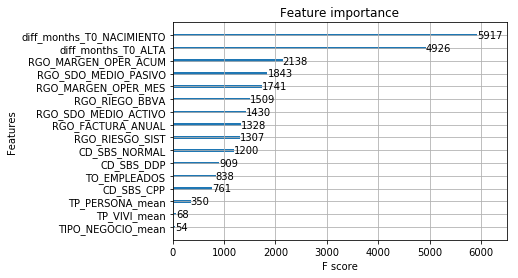

In [181]:
plot_importance(xgb2)
pyplot.show()

# Tercer modelo antes de mega merge. Computando nueva columna de diferencia de meses entre nacimiento y alta, y eliminando variables sin importancia

In [188]:
# Original X,y

df_stock_train_p.head(1).T

,0
ID,201808_48117
MES_T0,201808
ID_CLIENTE,48117
FUGA_3M,0
FH_NACIMIENTO,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,8
RGO_SDO_MEDIO_ACTIVO,6
RGO_SDO_MEDIO_PASIVO,9


In [197]:
df_stock_train_p['diff_months_ALTA_NACIMIENTO'] = df_stock_train_p['months_ALTA'] - df_stock_train_p['months_NACIMIENTO']
df_stock_test_p['diff_months_ALTA_NACIMIENTO'] = df_stock_test_p['months_ALTA'] - df_stock_test_p['months_NACIMIENTO']


In [198]:
fit_cols_3 = list(set(df_stock_train_p.columns)
                - set(cat_cols) 
                - set(intermediate_cols) 
                - set(['MES_T0','ID_CLIENTE','FH_ALTA','FH_NACIMIENTO',
                      'TP_PERSONA_J','TP_VIVI_HOGAR','TP_VIVI_LEGAL','TP_VIVI_TRABAJO','TP_VIVI_nan_value','TIPO_NEGOCIO_PNN','TIPO_NEGOCIO_Pyme']))

In [199]:
# Final datasets
df_stock_train_f_3 = df_stock_train_p[fit_cols_3]
df_stock_test_f_3 = df_stock_test_p[fit_cols_3]

In [210]:
df_stock_train_f_3.head(1).T

,0
CD_SBS_NORMAL,100
TP_PERSONA_A,0
CD_SBS_DDP,0
FUGA_3M,0
RGO_FACTURA_ANUAL,7
ID,201808_48117
TO_EMPLEADOS,2
RGO_SDO_MEDIO_ACTIVO,6
diff_months_T0_ALTA,11
RGO_MARGEN_OPER_MES,1


In [200]:
final_cols_3 = list(set(fit_cols_3)-set(['ID','FUGA_3M']))

In [202]:
X_3 = df_stock_train_f_3[final_cols_3]
y_3 = df_stock_train_f_3['FUGA_3M']

In [203]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.2, random_state = 42, stratify = y)

In [204]:
#Fitting
xgb3 = XGBClassifier(learning_rate =0.1,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scale_pos_weight=1,
                 seed=42)

In [205]:
xgb3.fit(X_train_3, y_train_3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
       subsample=0.8, verbosity=1)

In [207]:
#Getting results
y_pred_3 = xgb3.predict_proba(X_test_3)

In [208]:
roc_auc_score(y_test_3, y_pred_3[:,1]) 

0.7834752343683815

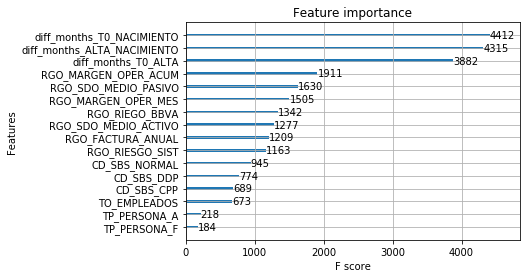

In [211]:
plot_importance(xgb3)
pyplot.show()

In [ ]:
# Hora de mergiar